In [1]:
import numpy as np

from tqdm.autonotebook import tqdm
import emcee
from multiprocessing import Pool
# Number of parameters
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import cv2
import os
import re
import pandas as pd
from radar_functions import *

# import own modules
import functions as func
from data_structures import ObsData, LightCurve, PartialLightCurve
from mcmc import ln_prob, ln_prior, ln_posterior, theor_curve

/tmp/ipykernel_314532/268141847.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def denoise_img(img: np.array) -> np.array:
    """denoises image"""
    img = (img * 255).astype(np.uint8)
    dst = cv2.fastNlMeansDenoising(img, 20,20,5,21) / 255
    dst = dst - np.quantile(dst, 0.1) 
    dst[dst < 0] = 0
    dst = dst / np.max(dst)
    return dst

def images_diff(params: tuple, radar_image_params: RadarImageParameters, 
                radar_images: list, position_vecs, mult=450, Nalpha=30):
    """
    calculates chi2 for the modeled lightcurve with the given parameters
    """
    ps = Parameters(a1=params[0] * mult, b1=params[1] * mult, c1=params[2] * mult,
                   a2=params[3] * mult, b2=params[4] * mult, c2=params[5] * mult,
                   l=params[6], b=params[7], init_phase=params[8], rot_per=params[9], radar_sat=params[10])
    # number of points in latitude and longitude used in ray tracing
    cosl = math.cos(ps.ecl_longitude)
    sinl = math.sin(ps.ecl_longitude)
    cosb = math.cos(ps.ecl_latitude)
    sinb = math.sin(ps.ecl_latitude)
    # distance between the components of the binary
    distance_primary = (ps.a1 + ps.a2) * ps.a2 * ps.b2 * ps.c2 / (ps.a1 * ps.b1 * ps.c1 + ps.a2 * ps.b2 * ps.c2)
    distance_secondary = (ps.a1 + ps.a2) * ps.a1 * ps.b1 * ps.c1 / (ps.a1 * ps.b1 * ps.c1 + ps.a2 * ps.b2 * ps.c2)
    # create two components of the binary
    primary = EllipsoidR(ps.a1, ps.b1, ps.c1, -distance_primary)
    secondary = EllipsoidR(ps.a2, ps.b2, ps.c2, distance_secondary)
    primary.ecl_latitude = ps.ecl_latitude
    secondary.ecl_latitude = ps.ecl_latitude
    primary.ecl_longitude = ps.ecl_longitude
    secondary.ecl_longitude = ps.ecl_longitude
    diff_total = []
    imgs = []
    #subplot(r,c) provide the no. of rows and columns
    for idx_img in range(radar_image_params.N_points):
        if radar_image_params.presence[idx_img] == 1:
            phi = 2*math.pi*(radar_image_params.jd[idx_img]-59185.77807) / ps.rot_per + ps.init_phase
            sinphi = math.sin(phi)
            cosphi= math.cos(phi)
            ex0 = position_vecs['x'].iloc[idx_img]
            ey0 = position_vecs['y'].iloc[idx_img]
            ez0 = position_vecs['z'].iloc[idx_img]
            ex,ey,ez = rotate(ex0,ey0,ez0,
                              sinl,cosl,sinb,cosb,
                              sinphi,cosphi)
            observed_radar_brightness = radar_images[idx_img]
            # pad the observed radar image with 15 pixels on each side
            observed_radar_brightness = np.pad(observed_radar_brightness, 10, 'constant', constant_values=0)
            
            theoretical_radar_brightness_list = theoretical_radar_image(primary=primary,
                                                                       secondary=secondary,
                                                                       ex=ex, ey=ey, ez=ez,
                                                                       P=ps.rot_per,
                                                                       N_radar_pixels=
                                                                       observed_radar_brightness.shape[0],
                                                                       dr=radar_image_params.dr[idx_img],
                                                                       dnu=0.96, Nalpha=Nalpha)
            saturate_theoretical_radar_image(theoretical_radar_brightness_list, params=ps)
            
            # shift theoretical image 
            theoretical_radar_brightness = np.array(theoretical_radar_brightness_list) - 0.1
            x_center_theor, y_center_theor = func.center_of_mass(theoretical_radar_brightness)
            x_center_obs, y_center_obs = func.center_of_mass(observed_radar_brightness - np.median(observed_radar_brightness))
            shift_x = x_center_obs - x_center_theor
            shift_y = y_center_obs - y_center_theor
            theoretical_radar_brightness = np.roll(theoretical_radar_brightness, int(shift_y), axis=1)
            theoretical_radar_brightness = np.roll(theoretical_radar_brightness, int(shift_x), axis=0)
            # # transform grayscale theoretical image to rgb red filter
            # calculate difference between theoretical and observed images
            diff = img_difference(observed_radar_brightness, theoretical_radar_brightness)
            color_image = np.zeros((observed_radar_brightness.shape[0], observed_radar_brightness.shape[1], 3), dtype=np.uint8)
            color_image[:, :, 0] = theoretical_radar_brightness * 255
            color_image[:, :, 1] = observed_radar_brightness * 255
            color_image[:, :, 2] = observed_radar_brightness * 255
            imgs.append(color_image)
            diff_total.append(diff)
    
    return diff_total, imgs


In [3]:
# get state vectors of the Earth and the Sun from JPL Horizons database
asteroid_name = "2000 WO107" 
lightcurve = LightCurve()  # container to store partial lightcurves
earth_data = ObsData()     # store earth vectors
sun_data = ObsData()       # store sun vectors
# get names of the lightcurve files
fnames = [f for f in os.listdir('light_curves') if re.match(r'.*\.dat', f)]
fnames.sort()
# read and parse partial lightcurve files
for fname in fnames[:4]:
    part_curve = pd.read_fwf(f'light_curves/{fname}', header=None, names=['epoch', 'mag', 'mag_err'])
    lightcurve += PartialLightCurve(part_curve)
for fname in fnames[4:]:
    part_curve = pd.read_csv(f'light_curves/{fname}', header=None, names=['epoch', 'mag', 'mag_err'], sep='\t')
    part_curve['epoch'] = part_curve['epoch'].astype(float) + 2400000.5
    lightcurve += PartialLightCurve(part_curve)
# sort lightcurves in the ascending order of the epoch
lightcurve.sort_lightcurves()
start_epoch = lightcurve.joined['epoch'].min()
reduc_epochs = lightcurve.joined['epoch'] - start_epoch
for i in range(len(lightcurve)):
    lightcurve.lightcurves[i].data['weight'] = (lightcurve.lightcurves[i].data['weight'] 
                                                / len(lightcurve.lightcurves[i]) * (len(lightcurve.joined) / len(lightcurve)))

In [4]:
# query JPL Horizons to get state vectors of the Sun and the Earth
for part_curve in tqdm(lightcurve, total=len(lightcurve), desc='Querying JPL Horizons'):
    epochs = part_curve.data.epoch.to_list()
    state_vecs_sun = func.get_object_orbit(asteroid_name, epochs=epochs,  location='@10', data_type='vectors') 
    # @399 - Earth
    state_vecs_earth = func.get_object_orbit(asteroid_name, epochs=epochs,  location='@399', data_type='vectors') 
    # calculate reduc epoch (counting from start epoch)
    state_vecs_sun['reduc_epoch'] = state_vecs_sun['epoch'] - start_epoch
    state_vecs_earth['reduc_epoch'] = state_vecs_earth['epoch'] - start_epoch
    # inverse signs of vectors
    state_vecs_sun[['x', 'y', 'z']] = -state_vecs_sun[['x', 'y', 'z']]
    state_vecs_earth[['x', 'y', 'z']] = -state_vecs_earth[['x', 'y', 'z']]
    sun_data += state_vecs_sun
    earth_data += state_vecs_earth

Querying JPL Horizons:   0%|          | 0/12 [00:00<?, ?it/s]

In [6]:
radar_image_params = RadarImageParameters("radar_data/data.txt")
# radar_images_obs = [np.array(read_observed_radar_image(radar_image_params,idx_img)) for idx_img in range(radar_image_params.N_points)]
radar_images_obs = [denoise_img(np.array(read_observed_radar_image(radar_image_params,idx_img))) 
                    for idx_img in range(radar_image_params.N_points)]


query_dates = [radar_image_params.jd[idx_img] + 2400000.5 for idx_img in range(len(radar_image_params.jd))]
state_vecs_earth = func.get_object_orbit('2000 WO107', epochs=query_dates,  location='@399', data_type='vectors')
state_vecs_earth['r'] = np.sum(state_vecs_earth[['x', 'y', 'z']] ** 2, axis=1)**0.5
position_vecs = (state_vecs_earth[['x', 'y', 'z']].T / state_vecs_earth['r']).T
#position_vecs.to_csv('input_data/position_vecs.csv', index=False)

In [7]:
n_procs = 6  # number of processes (cores) to use
nwalkers = n_procs * 3  # number of probe points

coeff = 0.2
init_ps = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0.0]
init_params = np.array([init_ps[0]  + coeff * np.random.randn(nwalkers),  # b1
                        init_ps[1]  + coeff * np.random.randn(nwalkers),  # c1
                        init_ps[2]  + coeff * np.random.randn(nwalkers),  # a2
                        init_ps[3]  + coeff * np.random.randn(nwalkers),  # b2
                        init_ps[4]  + coeff * np.random.randn(nwalkers),  # c2
                        init_ps[5]  + coeff * np.random.randn(nwalkers),  # c2
                        0 + np.random.uniform(low=0, high=2 * math.pi, size=nwalkers), 
                        0 + np.random.uniform(low=-math.pi /2, high=math.pi /2, size=nwalkers), 
                        0 + np.random.uniform(low=0, high=2 * math.pi, size=nwalkers)]).T
ndim = np.size(init_params, axis=1)  # number of parameters
init_params = init_params.astype(float)

In [8]:
with Pool(processes=n_procs) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_prob, 
                                    args=(radar_image_params, radar_images_obs, position_vecs,
                                          lightcurve, earth_data, sun_data), 
                                    pool=pool,
                                    #moves=emcee.moves.GaussianMove(cov=cov_mat))
                                    moves=[(emcee.moves.DEMove(), 0.8),
                                           (emcee.moves.DESnookerMove(), 0.2)])
    # Run the MCMC sampler
    nsteps = 100
    burn_in = 1
    # starting points for every walker
    #init_p = np.random.rand(nwalkers, ndim)
    pos, prob, state = sampler.run_mcmc(init_params, nsteps, progress=True)
    # Get the samples after burn-in
    samples = sampler.get_chain(discard=burn_in, flat=True)

# Plot the scatter plot of data and fitted model
best_fit_params = np.median(samples, axis=0)
#best_fit_params = np.insert(best_fit_params, 0, 1.0)
fit_curve = theor_curve(best_fit_params, earth_data, sun_data)

  0%|          | 0/100 [00:00<?, ?it/s]/home/igor/anaconda3/envs/sandbox/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
 14%|█▍        | 14/100 [00:03<00:20,  4.22it/s]Process ForkPoolWorker-2:
Process ForkPoolWorker-3:
Process ForkPoolWorker-6:
Process ForkPoolWorker-4:
Process ForkPoolWorker-1:
Process ForkPoolWorker-5:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/igor/anaconda3/envs/sandbox/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/igor/anaconda3/envs/sandbox/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/igor/anaconda3/envs/sandbox/lib/python3.12/multiprocessing/process.py", line 314, in _boots

In [ ]:
# import pickle
# file_pick = open('both_mcmc_26_08.obj', 'wb')
# pickle.dump(sampler, file=file_pick)

In [9]:
import pickle
file_pick = open('mcmc_results.obj', 'rb')
sampler = pickle.load(file_pick)

In [10]:
samples_flat = sampler.flatchain
samples = sampler.get_chain(flat=True)
flat_ln = sampler.flatlnprobability#[np.isfinite(sampler.flatlnprobability)]
samples = samples[np.argwhere(flat_ln != -np.inf), :][:, 0]
min_arg = flat_ln.argmax()
min_chi = flat_ln[min_arg]
print(f'len_samples_all: {len(samples_flat)}', f'len_samples_notna: {len(samples)}')
print(f"min_arg: {min_arg}, min_chi: {min_chi}")
best_params = samples_flat[min_arg]
#best_params = np.insert(best_params, 0, 1.0)
print("""best_params: a1 = {:.2f},  b1 = {:.2f}, c1 = {:.2f},
             a2 = {:.2f}, b2 = {:.2f}, c2 = {:.2f}, 
             lon = {:.2f}, lat = {:.2f}, phase = {:.2f}""".format(*best_params))


print('best:      ', [round(param, 4) for param in best_params])

len_samples_all: 1800 len_samples_notna: 400
min_arg: 918, min_chi: -196325.54407638096
best_params: a1 = 1.18,  b1 = 1.09, c1 = 1.06,
             a2 = 1.08, b2 = 0.82, c2 = 0.81, 
             lon = 4.71, lat = 0.98, phase = 2.38
best:       [1.1791, 1.0928, 1.0591, 1.0792, 0.8205, 0.8085, 4.7076, 0.9766, 2.3812, 0.1945, 1469.8326]


In [11]:
(best_params[0] * best_params[1] * best_params[2] + best_params[3] * best_params[4] * best_params[5])**1/3 * 2 * 450

624.1698845573718

In [12]:
b1_a1 = best_params[1] / best_params[0]
b1_a2 = best_params[1] / best_params[3]
print(b1_a1, b1_a2)

0.926813805898125 1.0126738507070598


/tmp/ipykernel_314532/4254854930.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.1, h_pad=-0.4, w_pad=0.0)


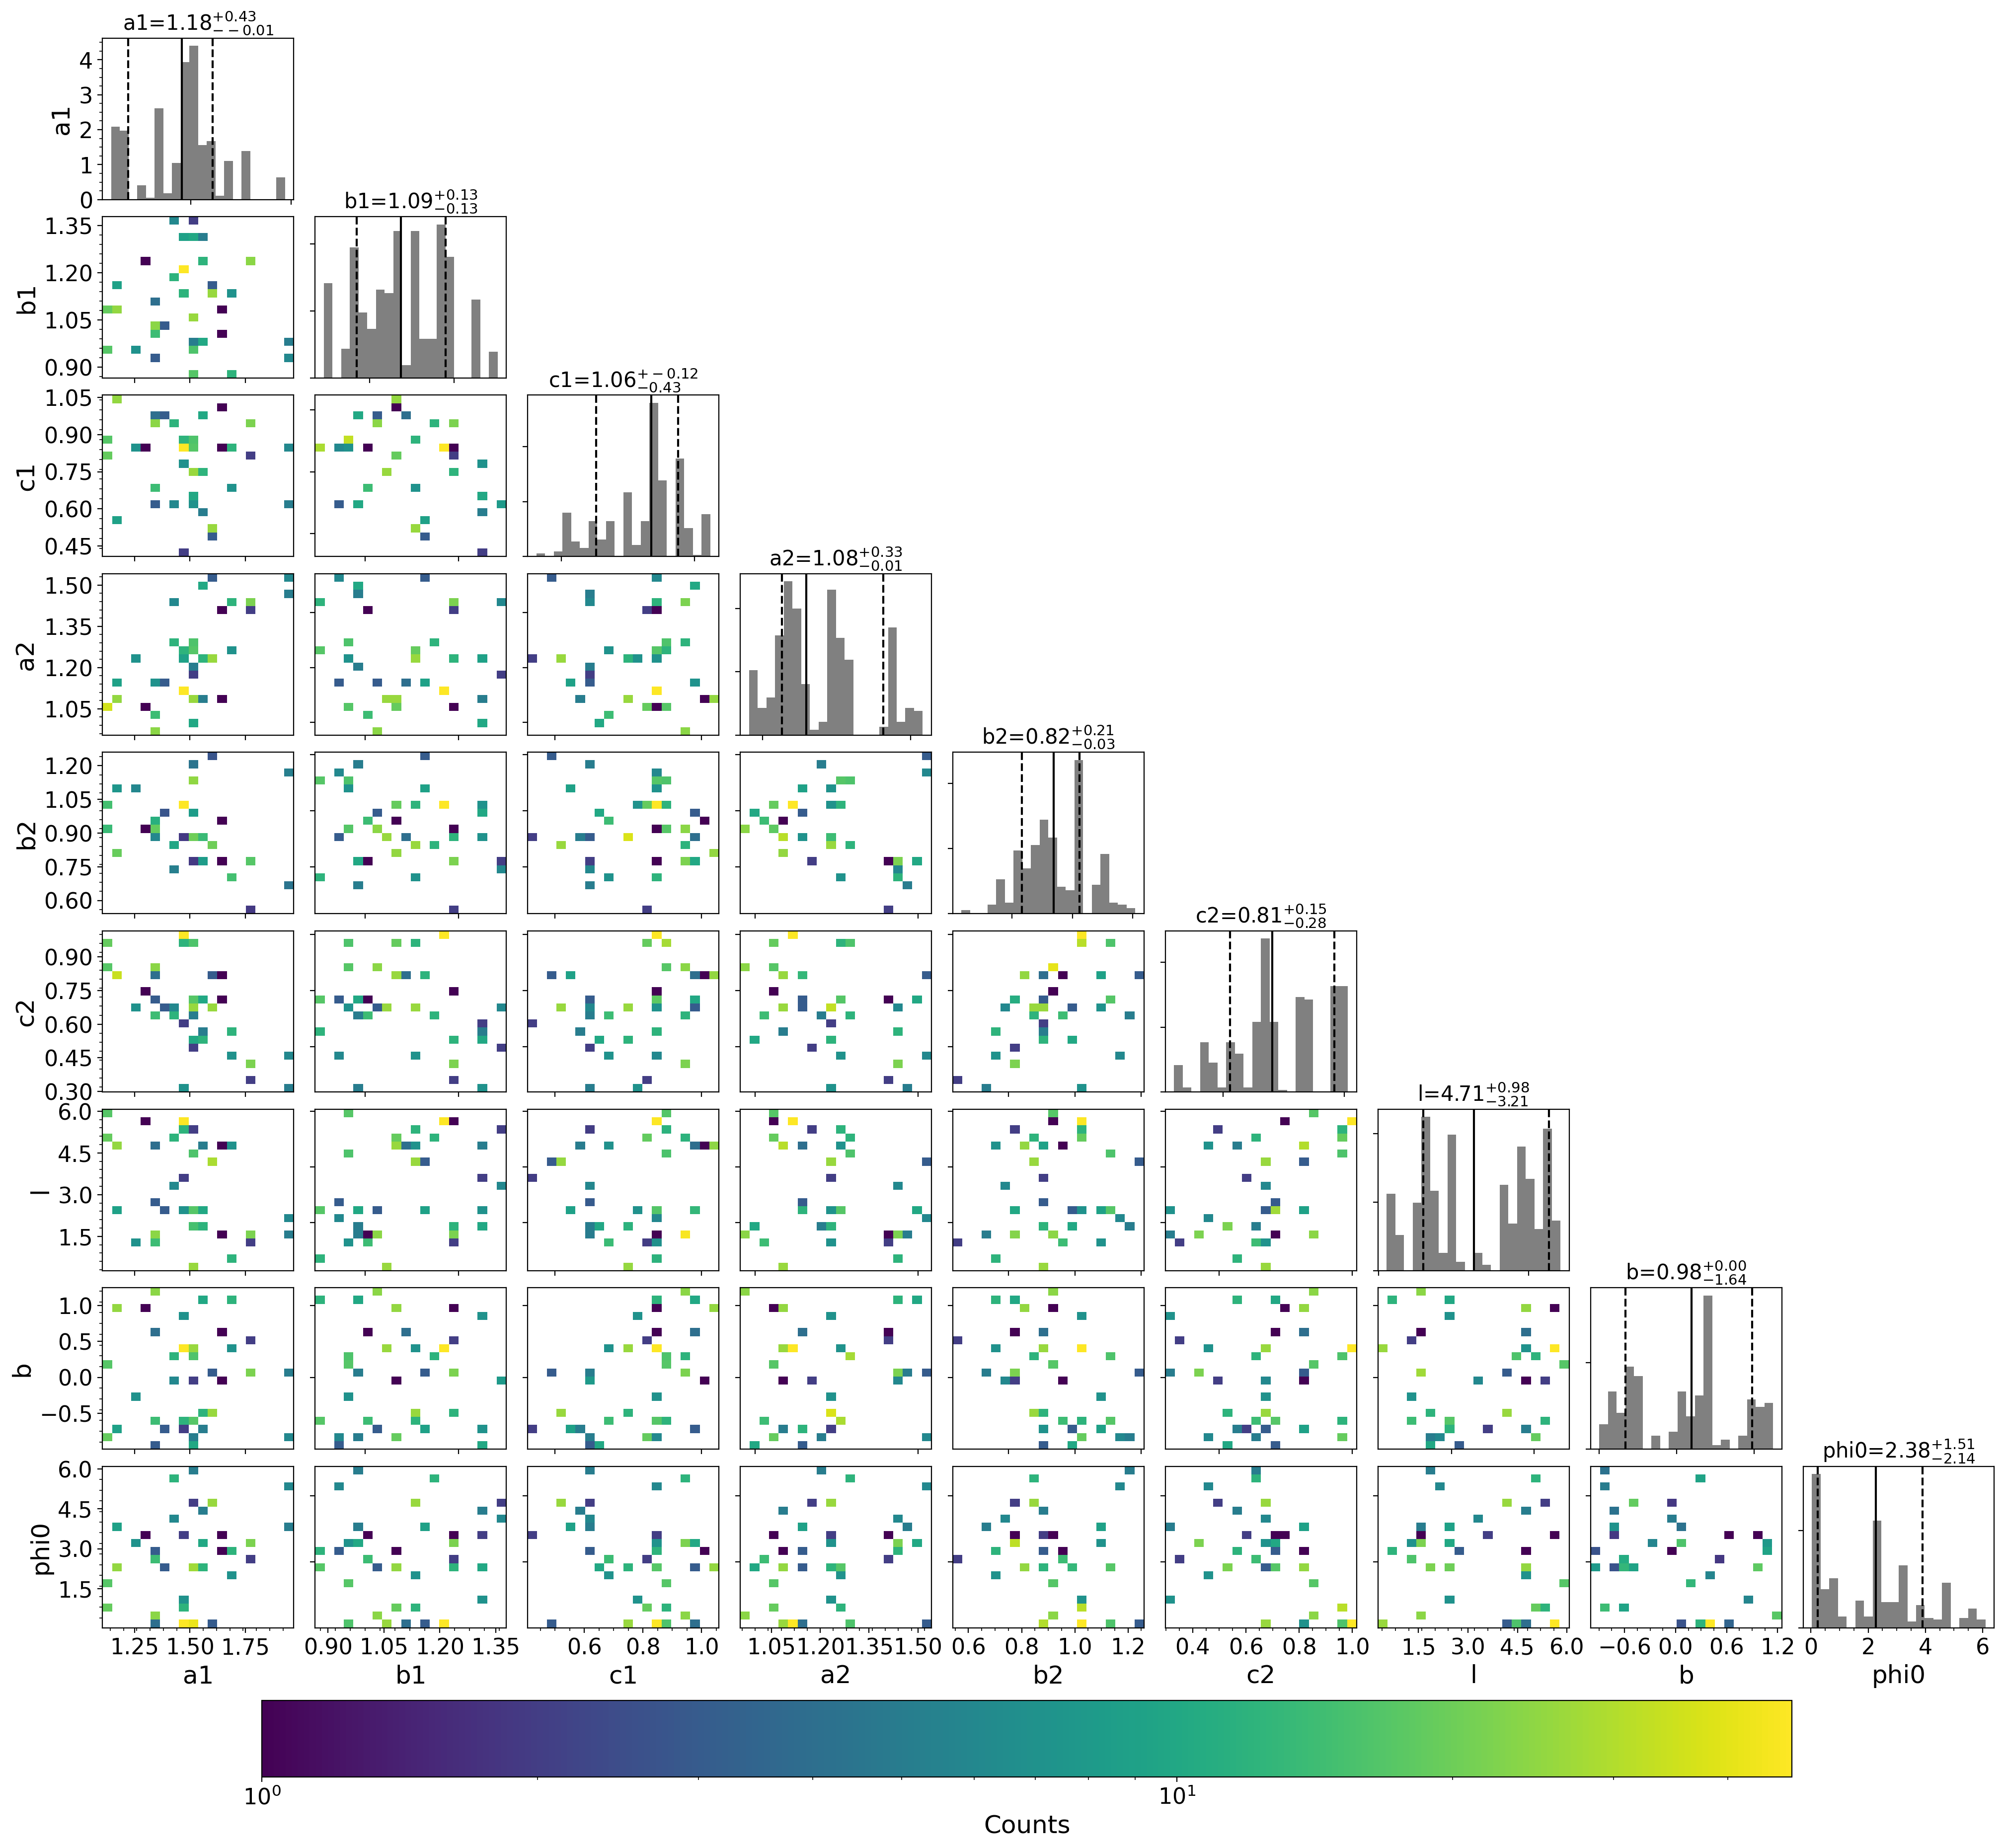

In [13]:
data = samples[:, :9]
#data = samples[np.argwhere(flat_ln >= min_chi*1.3), :9][:, 0]
num_params = data.shape[1]

labels=["a1", "b1", "c1", "a2", "b2", "c2", "l", "b", "phi0"]

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 15
# Create a figure with subplots
fig, axes = plt.subplots(num_params, num_params, figsize=(20, 20), dpi=200)
bins_heat = 20
bins_hist = 20
best_params_hist = samples_flat[min_arg]

# Variable to store the mappable object for the colorbar
mappable = None
# Plot the histograms and scatter plots
for i in range(num_params):
    for j in range(num_params):
        if i < j:
            # Skip the upper triangle and diagonal
            axes[i, j].axis('off')
        elif i == j:
            # get the desired percentiles
            data_axis = data[:, i]
            p16 = np.percentile(data_axis, q=16)
            p84 = np.percentile(data_axis, q=84)
            median = np.median(data_axis)
            # data_axis = data_axis[(data_axis >= p16) & (data_axis <= p84)]
            # Diagonal: plot histograms
            axes[i, j].hist(data_axis, bins=bins_hist, color='gray', density=True)


            axes[i, j].axvline(median, color='black')
            axes[i, j].axvline(p16, color='black', linestyle='--')
            axes[i, j].axvline(p84, color='black', linestyle='--')
            # Add title with median and percentiles
            axes[i, j].title.set_text(r'%s=${%.2f}_{-%.2f}^{+%.2f}$' % (labels[i], round(best_params_hist[i],2), 
                                                                  round(best_params_hist[i]-p16, 2), round(p84 - best_params_hist[i], 2)))
        else:
            # Off-diagonal: plot scatter plots
            data_j = data[:, j]
            data_i = data[:, i]
            p16j = np.percentile(data_j, q=0)
            p84j = np.percentile(data_j, q=100)
            idx_j = np.argwhere((data_j >= p16j) & (data_j <= p84j))
            # get the indexes for the 16th and 84th percentiles
            # p16i = np.percentile(data_i, q=16)
            # p84i = np.percentile(data_i, q=84)
            # data_i = data_i[(data_i >= p16) & (data_i <= p84)]
            
            h = axes[i, j].hist2d(data_j[idx_j][:, 0], data_i[idx_j][:, 0], bins=bins_heat, cmap='viridis', norm=LogNorm())
            if mappable is None:
                mappable = h[3]  # Store the mappable object for the colorbar
            #axes[i, j].set_xlabel(labels[j])
           
        # Remove labels for cleaner look
        if i < num_params - 1:
            axes[i, j].set_xticklabels([])
        if j > 0:
            axes[i, j].set_yticklabels([])
        
        # Add axis labels
        if i == num_params - 1:
            axes[i, j].set_xlabel(labels[j])
            axes[i, j].xaxis.set_major_locator(ticker.MaxNLocator(4))
            axes[i, j].xaxis.set_minor_locator(ticker.MaxNLocator(15))
        if j == 0:
            axes[i, j].set_ylabel(labels[i])
            axes[i, j].yaxis.set_major_locator(ticker.MaxNLocator(5))
            axes[i, j].yaxis.set_minor_locator(ticker.MaxNLocator(20))


# Add a colorbar at the bottom for all subplots
if mappable:
    cbar = fig.colorbar(mappable, ax=axes, orientation='horizontal', fraction=0.05, pad=-0.25, shrink=2.0)
    cbar.set_label('Counts')

# Adjust layout
plt.tight_layout(pad=0.1, h_pad=-0.4, w_pad=0.0)
#plt.savefig('images/correlation_mcmc.pdf', bbox_inches='tight', format='pdf') 
plt.show()

chi2 mcmc: 12918.411377
chi2 deg:  9984.750309
ch2 default: 13099.717530


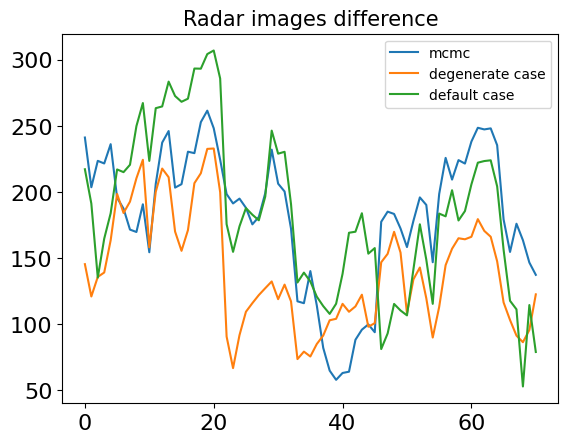

In [14]:
Nalpha=50
dalphadbeta = math.pi**2/Nalpha**2
#best_params =  [1.412, 0.9, 1.0, 0.75, 0.7, 0.6, 5.16, -1.294, 5.586]
#best_params = [1.087, 0.758, 0.753, 1.067, 0.971, 0.858, 3.539, -1.401, 3.845]
diff_best, imgs = images_diff(best_params, radar_image_params, radar_images_obs, position_vecs, mult=450, Nalpha=50)
diff_deg, imgs_deg = images_diff([1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 0, 0, 0, 5.022 / 24, 2000], radar_image_params, 
                           radar_images_obs, position_vecs)
diff_def, imgs_def = images_diff([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0,  5.022 / 24, 2000], radar_image_params, 
                           radar_images_obs, position_vecs)
plt.title('Radar images difference')
plt.plot(diff_best, label='mcmc')
plt.plot(diff_deg, label='degenerate case')
plt.plot(diff_def, label='default case')
plt.legend()
print(f'chi2 mcmc: {np.sum(diff_best):2f}',)
print(f'chi2 deg:  {np.sum(diff_deg):2f}')
print(f'ch2 default: {np.sum(diff_def):2f}')

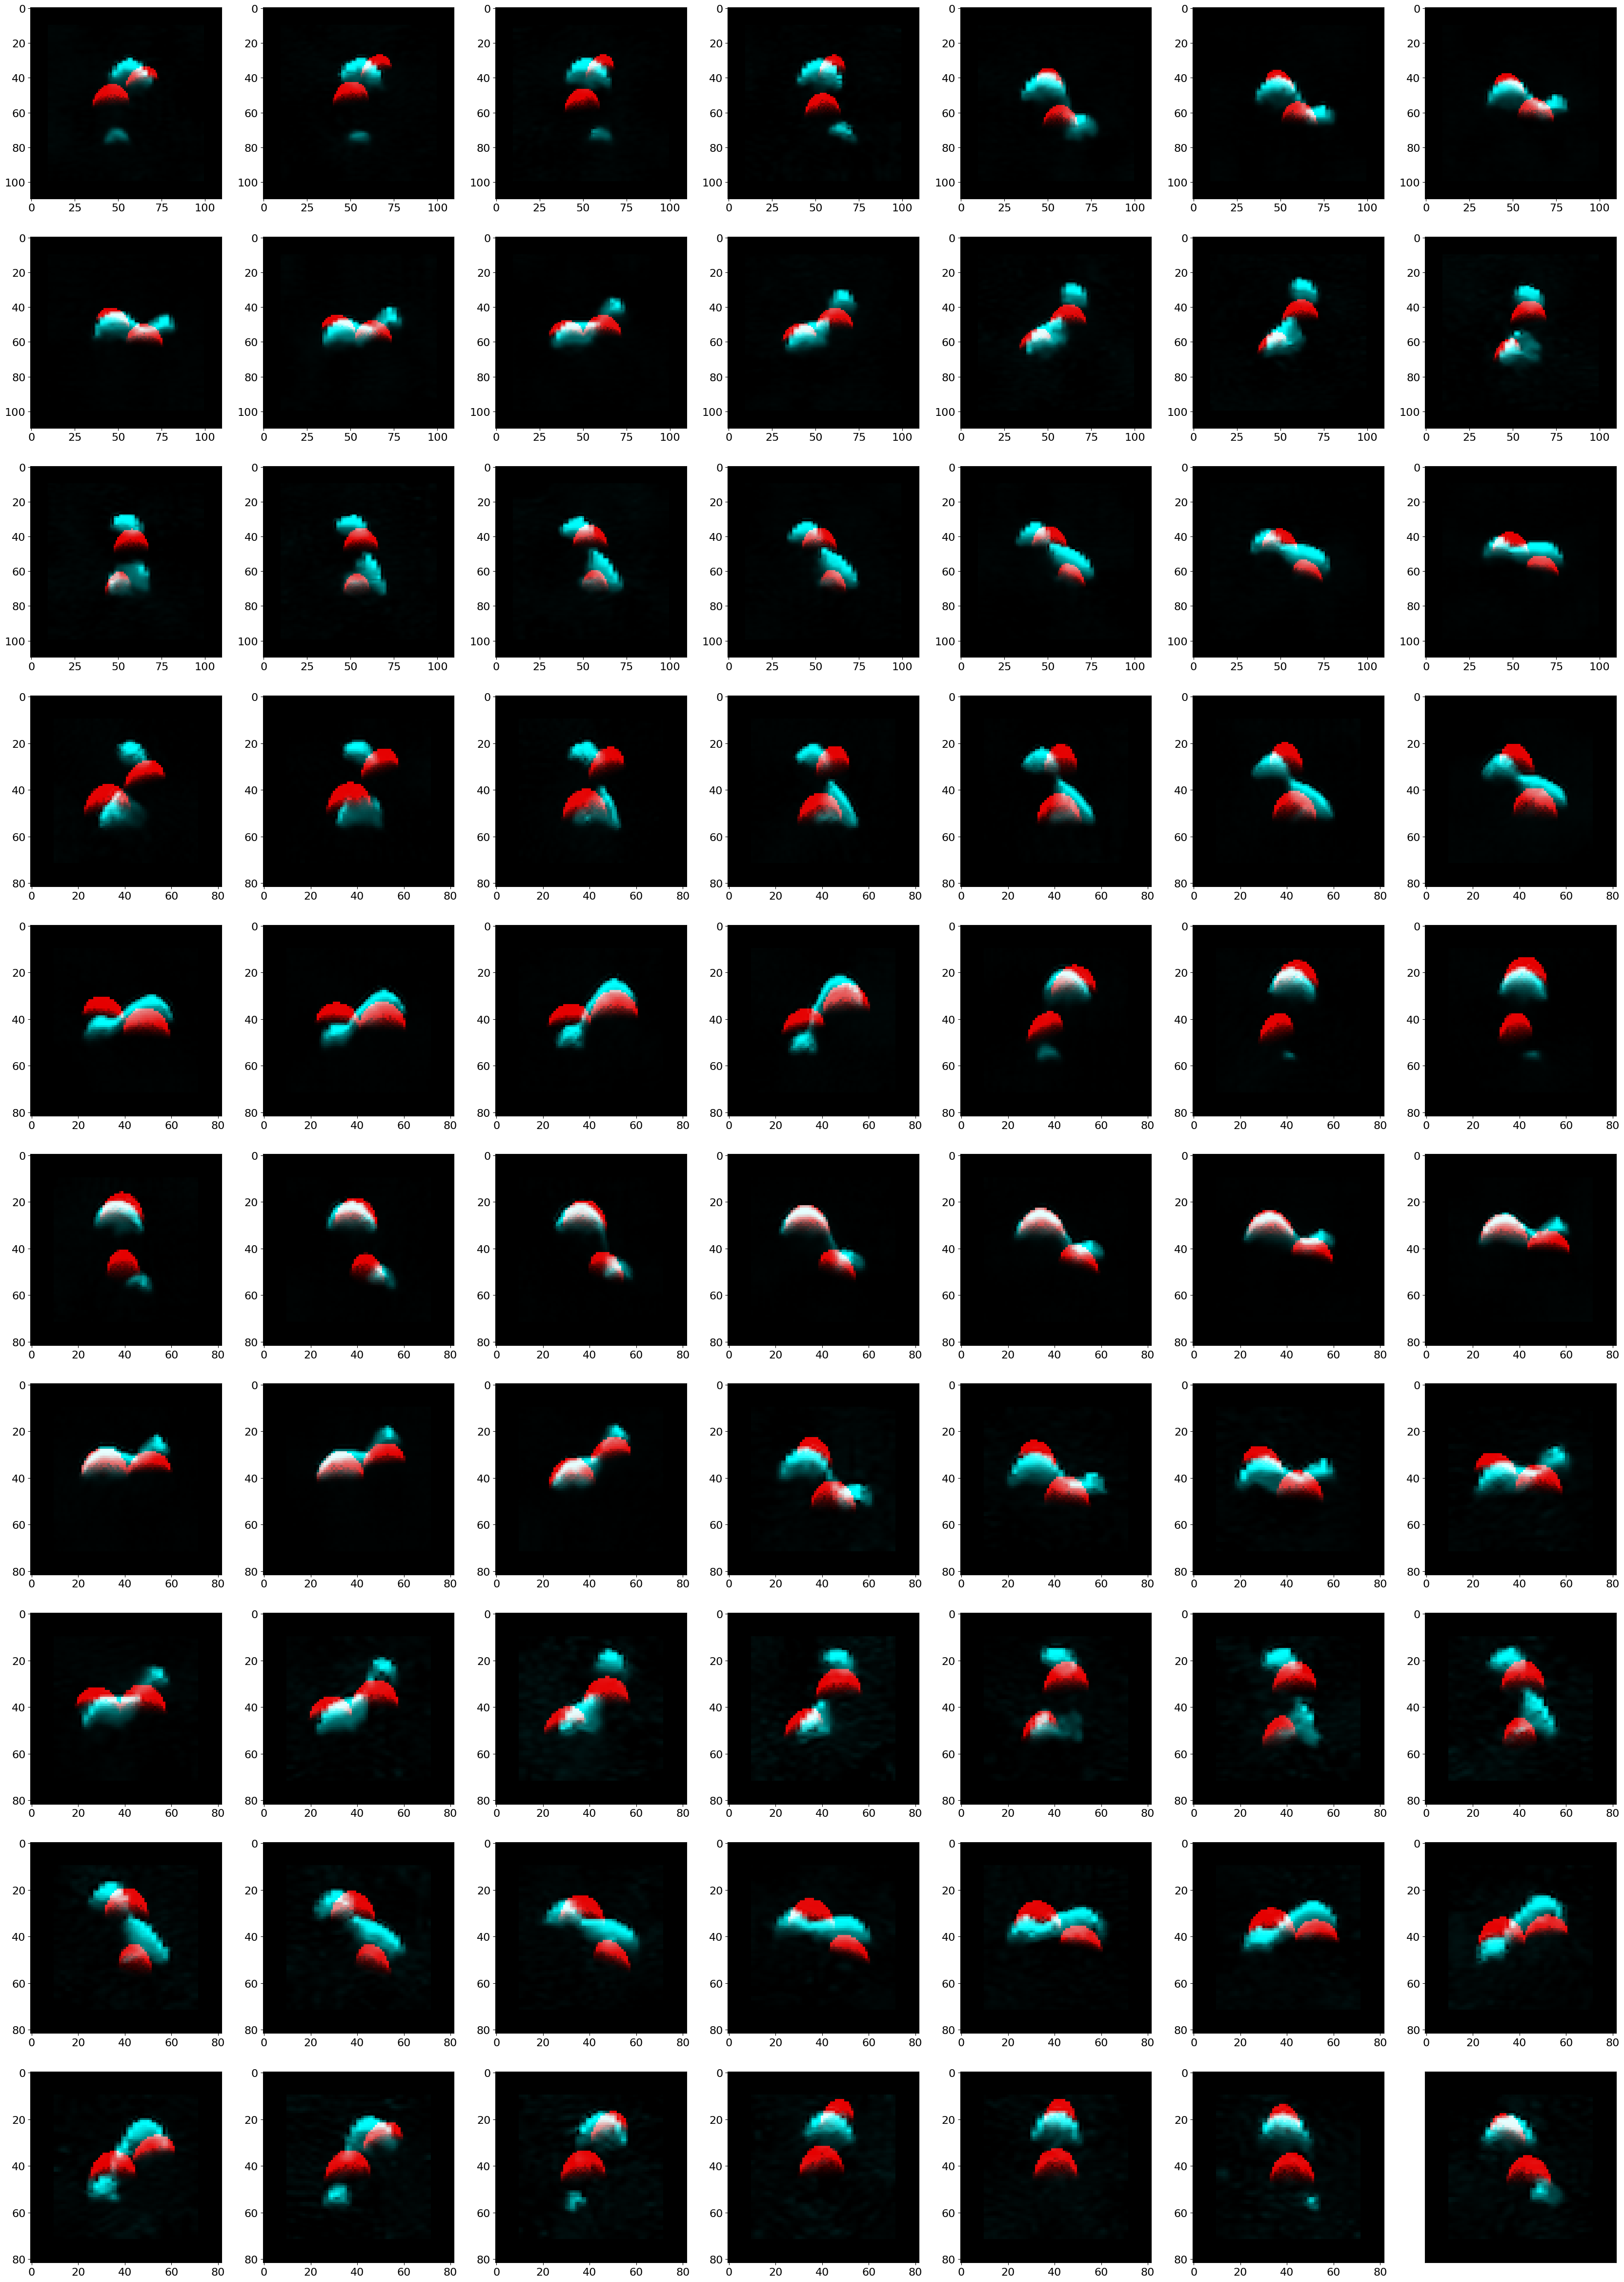

In [15]:
rows = 10
cols = 7
fig, axarr = plt.subplots(rows, cols, figsize=(6 * cols, 6 * rows), dpi=100)
for idx_img in range(1, 71):
    # use the created array to output your multiple images. In this case I have stacked 4 images vertically
    axarr[(idx_img-1) // cols][(idx_img-1) % cols].imshow(imgs[idx_img], interpolation='nearest')
    plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 

#plt.savefig('images/radar_images.pdf', bbox_inches='tight', format='pdf') 
plt.show()

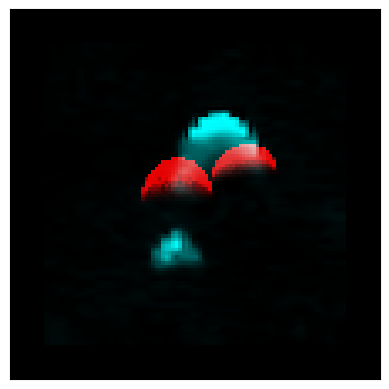

In [16]:
plt.imshow(imgs[0], interpolation='nearest')
plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
#plt.savefig('images/radar_image_1.pdf', bbox_inches='tight', format='pdf') 
plt.show()

In [17]:

lightcurve_theor = theor_curve(params=best_params, earth_data=earth_data, sun_data=sun_data)
# calculate how much the part of the observational curve have to be shifted up/down
lightcurve.calculate_shifts(other=lightcurve_theor)
# shift observed data (lightcurves) by the amount of vertical shift
lightcurve.shift_curves()

χ^2_part0 = 18615.7,
χ^2 total = 295233.3


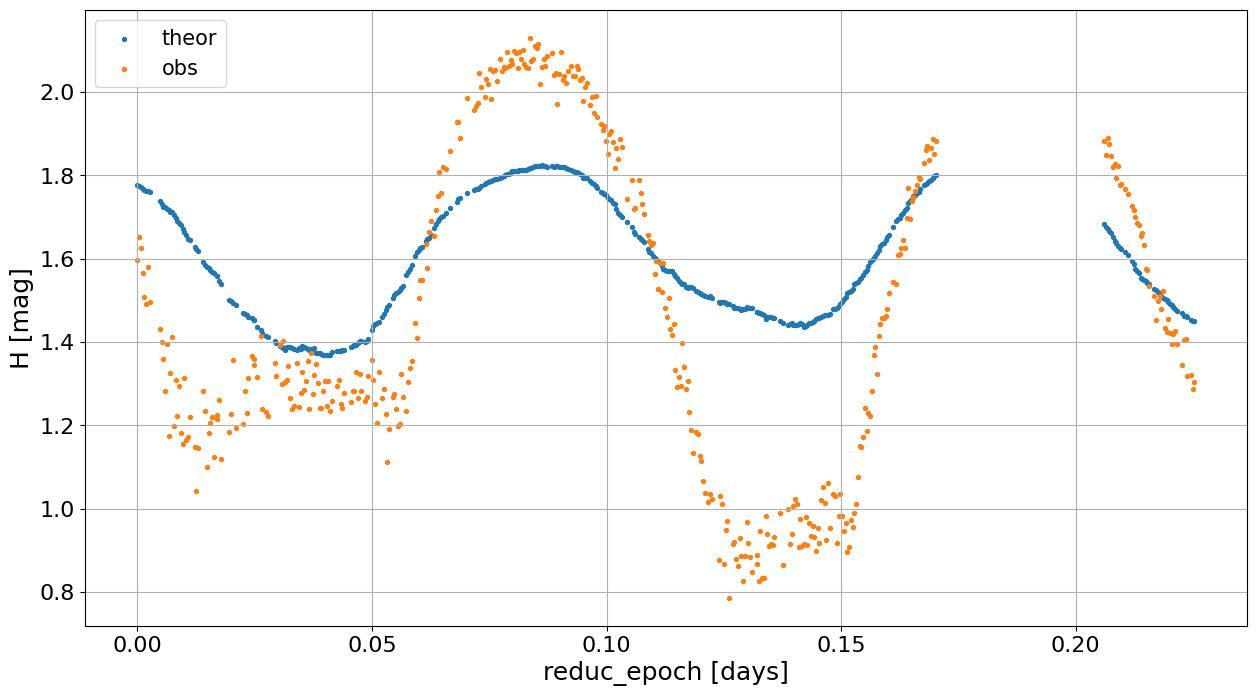

In [19]:

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 15
plt.figure(figsize=(15, 8))
idx = 0
lc = lightcurve.lightcurves[idx].data
plt.scatter(sun_data[idx]['reduc_epoch'], -lightcurve_theor[idx], s=8, label='theor')
plt.scatter(sun_data[idx]['reduc_epoch'], -lightcurve.lightcurves[idx].data['mag_shifted'], s=8, label='obs')

plt.xlabel('reduc_epoch [days]')
plt.ylabel('H [mag]')
plt.legend(loc='upper left', prop = { "size": 15 })
plt.grid()
# calculate chi-squared
print(lc['weight'].iloc[0])
chi2_part = np.sum((lc['mag_shifted'] 
               - lightcurve_theor[idx]) ** 2 / lc['mag_err']  ** 2)# * lc['weight'].iloc[0])
# calculate chi-squared
chi2 = np.sum((lightcurve.joined['mag_shifted'] 
               - lightcurve_theor.joined) ** 2 / lightcurve.joined['mag_err'] ** 2 * lightcurve.joined['weight'])
print(f"\u03C7^2_part{idx} = {chi2_part:.1f},\n\u03C7^2 total = {chi2:.1f}") 
#plt.savefig('images/lc_mcmc_1.pdf', bbox_inches='tight', format='pdf') 

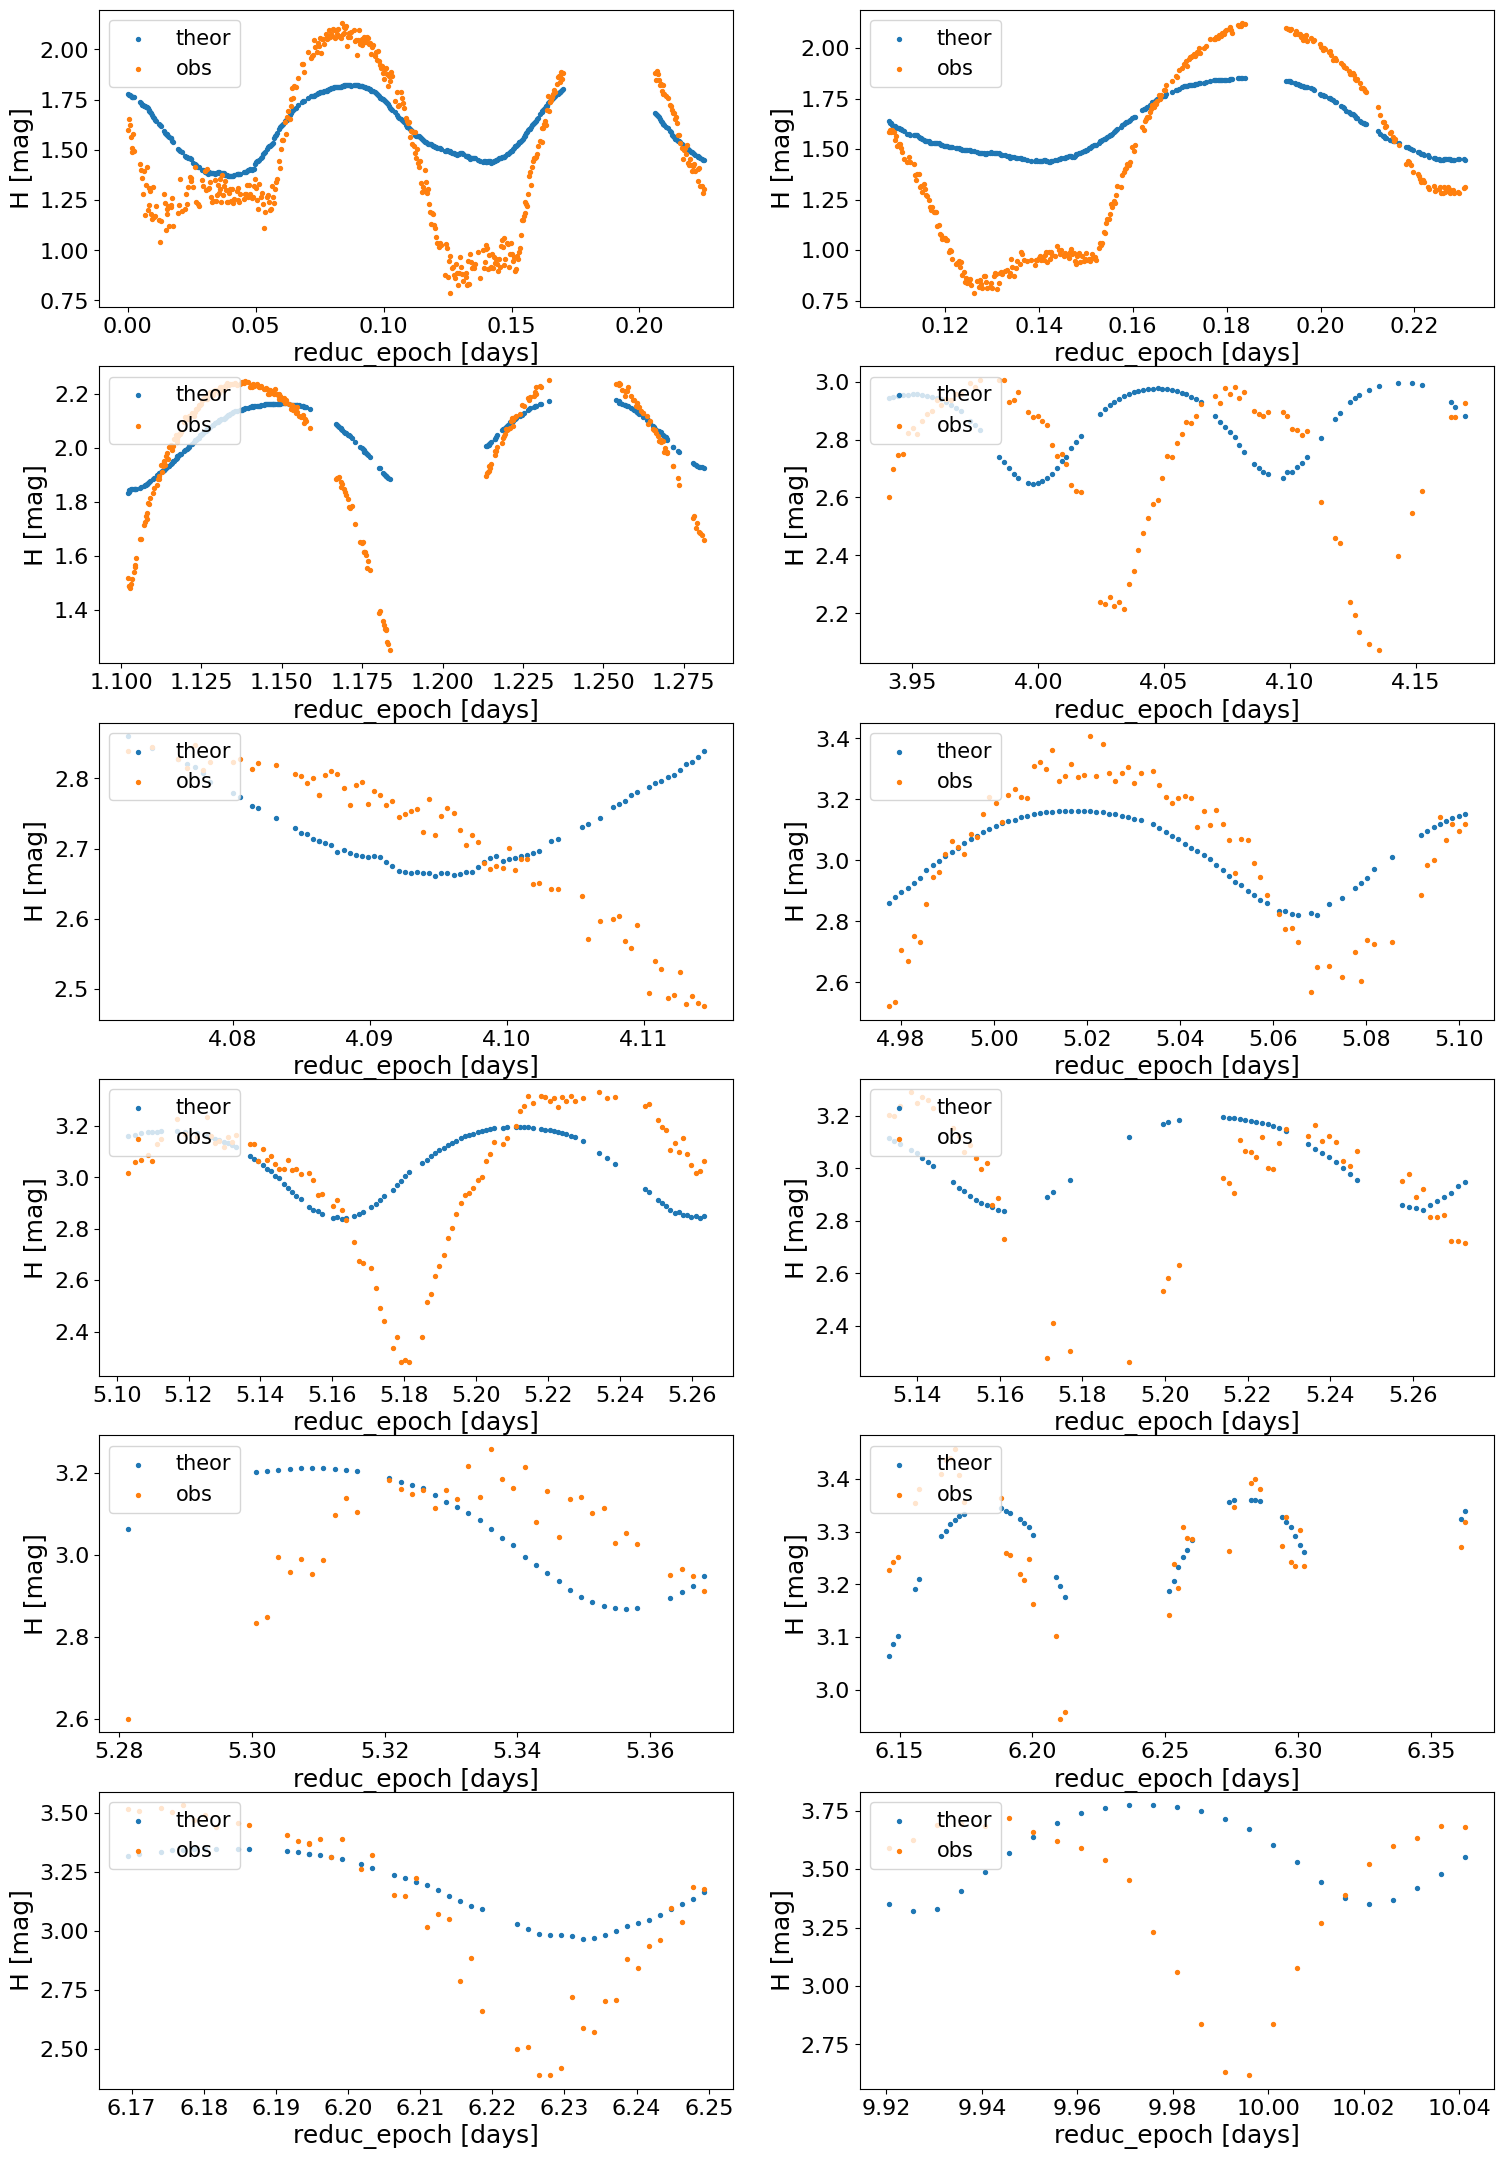

In [22]:
rows = 6
cols = 2
fig, axarr = plt.subplots(rows, cols, figsize=(9 * cols, 4.5 * rows), dpi=100)
for idx in range(0, len(lightcurve.lightcurves)):
    lc = lightcurve.lightcurves[idx].data
    axarr[(idx) // cols][(idx) % cols].scatter(sun_data[idx]['reduc_epoch'], -lightcurve_theor[idx], s=8, label='theor')
    axarr[(idx) // cols][(idx) % cols].scatter(sun_data[idx]['reduc_epoch'], -lightcurve.lightcurves[idx].data['mag_shifted'], s=8, label='obs')
    
    axarr[(idx) // cols][(idx) % cols].set_xlabel('reduc_epoch [days]')
    axarr[(idx) // cols][(idx) % cols].set_ylabel('H [mag]')
    axarr[(idx) // cols][(idx) % cols].legend(loc='upper left', prop = { "size": 15 })

#plt.savefig('images/lc_mcmc_all.pdf', bbox_inches='tight', format='pdf') 

In [23]:
func.estimate_density(*best_params[:6].T, rot_per=5.022/24)

2391.5713996453546

(array([61., 72., 13., 16., 59.,  0., 43., 27.,  7., 16., 25., 29.,  7.,
         0.,  2., 12.,  0.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  5.]),
 array([ 2210.27980726,  2523.78774628,  2837.29568529,  3150.80362431,
         3464.31156333,  3777.81950234,  4091.32744136,  4404.83538038,
         4718.34331939,  5031.85125841,  5345.35919743,  5658.86713644,
         5972.37507546,  6285.88301447,  6599.39095349,  6912.89889251,
         7226.40683152,  7539.91477054,  7853.42270956,  8166.93064857,
         8480.43858759,  8793.9465266 ,  9107.45446562,  9420.96240464,
         9734.47034365, 10047.97828267, 10361.48622169, 10674.9941607 ,
        10988.50209972, 11302.01003874, 11615.51797775]),
 <BarContainer object of 30 artists>)

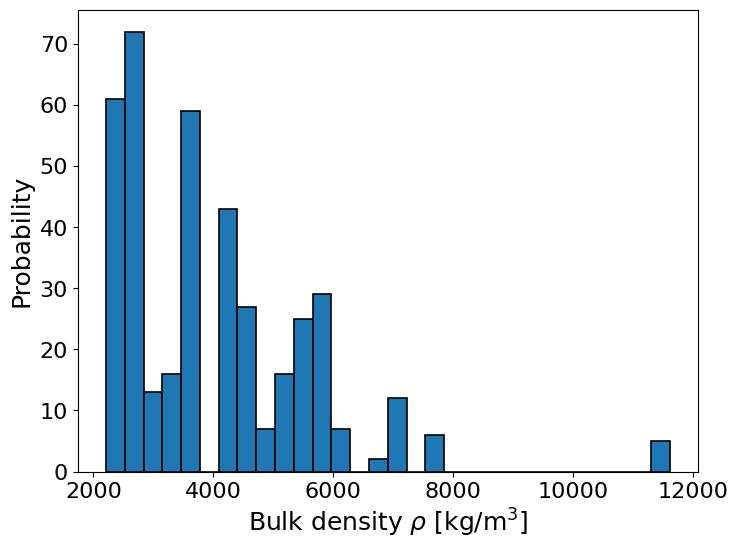

In [24]:
# calculate the density for the asteroid7
density = func.estimate_density(*samples[:, :6].T, rot_per=5.022/24)
plt.figure(figsize=(8, 6))
plt.xlabel(r"Bulk density $\rho$ [kg/m$^3$]")
plt.ylabel("Probability")
plt.hist(density, bins=30, edgecolor='black', linewidth=1.2, density=False)

In [257]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, HBox, VBox, widgets, Layout

# Define the function to update the plot
def interactive_plot(a1=1, b1=1, c1=1, a2=1, b2=1, c2=1, lon=0, lat=0, init_phase=0):
    parameters = Parameters()
    mult = 450
    parameters.a1 = a1 * mult
    parameters.b1 = b1 * mult
    parameters.c1 = c1 * mult
    parameters.a2 = a2 * mult
    parameters.b2 = b2 * mult
    parameters.c2 = c2 * mult
    parameters.ecl_longitude = lon
    parameters.ecl_latitude = lat
    parameters.phi0 = init_phase
    #number of points in latitude and longitude used in ray tracing
    cosl = math.cos(parameters.ecl_longitude)
    sinl = math.sin(parameters.ecl_longitude)
    cosb = math.cos(parameters.ecl_latitude)
    sinb = math.sin(parameters.ecl_latitude)
    primary = EllipsoidR(parameters.a1, parameters.b1, parameters.c1,
                    -(parameters.a1+parameters.a2)
                    *parameters.a2*parameters.b2*parameters.c2
                    / (parameters.a1*parameters.b1*parameters.c1
                       +parameters.a2*parameters.b2*parameters.c2))
    secondary = EllipsoidR(parameters.a2,parameters.b2,parameters.c2,
                      (parameters.a1+parameters.a2)
                      *parameters.a1*parameters.b1*parameters.c1
                      / (parameters.a1*parameters.b1*parameters.c1
                         +parameters.a2*parameters.b2*parameters.c2))
    diff_total = []
    imgs = []
    num_imgs = 5
    start = 60
    #subplot(r,c) provide the no. of rows and columns
    for idx_img in range(start, start + num_imgs):
        if radar_image_params.presence[idx_img] == 1:
            phi = 2*math.pi*(radar_image_params.jd[idx_img]-59185.77807)/parameters.P + parameters.phi0
            sinphi = math.sin(phi)
            cosphi= math.cos(phi)
            ex0 = position_vecs['x'].iloc[idx_img]
            ey0 = position_vecs['y'].iloc[idx_img]
            ez0 = position_vecs['z'].iloc[idx_img]
            ex,ey,ez = rotate(ex0,ey0,ez0,
                              sinl,cosl,sinb,cosb,
                              sinphi,cosphi)
            observed_radar_brightness = radar_images_obs[idx_img]
            theoretical_radar_brightness_list = theoretical_radar_image(primary=primary,
                                                                        secondary=secondary,
                                                                        ex=ex, ey=ey, ez=ez,
                                                                        P=parameters.P, 
                                                                        N_radar_pixels=radar_image_params.size_px[idx_img],
                                                                        dr=radar_image_params.dr[idx_img], 
                                                                        dnu=radar_image_params.dnu[idx_img], Nalpha=30)
            saturate_theoretical_radar_image(theoretical_radar_brightness_list, parameters)
            
            # shift theoretical image 
            theoretical_radar_brightness = np.array(theoretical_radar_brightness_list) - 0.1
            x_center_theor, y_center_theor = func.center_of_mass(theoretical_radar_brightness)
            x_center_obs, y_center_obs = func.center_of_mass(observed_radar_brightness - np.median(observed_radar_brightness))
            shift_x = x_center_obs - x_center_theor
            shift_y = y_center_obs - y_center_theor
            try:
                theoretical_radar_brightness = np.roll(theoretical_radar_brightness, int(shift_y), axis=1)
                theoretical_radar_brightness = np.roll(theoretical_radar_brightness, int(shift_x), axis=0)
            except:
                print(shift_x, shift_y)
                continue
            # calculate difference between theoretical and observed images
            diff = img_difference(observed_radar_brightness, theoretical_radar_brightness)
            diff_total.append(diff)
            #print(shift_x, shift_y)
            imgs.append([theoretical_radar_brightness, 
                         observed_radar_brightness, 
                         (observed_radar_brightness-theoretical_radar_brightness)])
            diff_total.append(img_difference(theoretical_radar_brightness, observed_radar_brightness))
    
    fig, axarr = plt.subplots(3, num_imgs, figsize=(4 * num_imgs, 8))
    for idx_img in range(0, num_imgs):
        # use the created array to output your multiple images. In this case I have stacked 4 images vertically
        axarr[0][idx_img].imshow(imgs[idx_img][0], cmap='gray', interpolation='nearest')
        axarr[1][idx_img].imshow(imgs[idx_img][1], cmap='gray', interpolation='nearest')
        axarr[2][idx_img].imshow(imgs[idx_img][2], cmap='gray', interpolation='nearest')
    
    print('total similarity:', sum(diff_total))
    
#best_params = [a1_slider.value, b1_slider.value, c1_slider.value, a2_slider.value, b2_slider.value, c2_slider.value,
#               lon_slider.value, round(lat_slider.value, 2), init_phase_slider.value]

width_sliders = Layout(width='400px')
# Create sliders
a1_slider = widgets.FloatSlider(value=best_params[0], min=0, max=3.0, step=0.01, description='a1', layout=width_sliders)
b1_slider = widgets.FloatSlider(value=best_params[1], min=0, max=3.0, step=0.01, description='b1', layout=width_sliders)
c1_slider = widgets.FloatSlider(value=best_params[2], min=0, max=3.0, step=0.01, description='c1', layout=width_sliders)
a2_slider = widgets.FloatSlider(value=best_params[3], min=0, max=3.0, step=0.01, description='a2', layout=width_sliders)
b2_slider = widgets.FloatSlider(value=best_params[4], min=0, max=3.0, step=0.01, description='b2', layout=width_sliders)
c2_slider = widgets.FloatSlider(value=best_params[5], min=0, max=3.0, step=0.01, description='c2', layout=width_sliders)
lon_slider = widgets.FloatSlider(value=best_params[6], min=0, max=np.pi * 2, step=0.01, description='lon', layout=width_sliders)
lat_slider = widgets.FloatSlider(value=best_params[7], min=-np.pi, max=np.pi, step=0.01, description='lat', layout=width_sliders)
init_phase_slider = widgets.FloatSlider(value=best_params[8], min=0, max=np.pi * 2, step=0.01, description='init_phase', layout=width_sliders)

# Group sliders in two columns
left_box = VBox([a1_slider, b1_slider, c1_slider, a2_slider, b2_slider, c2_slider])
right_box = VBox([lon_slider, lat_slider, init_phase_slider])


# Make interactive widget
ui = HBox([left_box, right_box])
out = interactive(interactive_plot, a1=a1_slider, b1=b1_slider, c1=c1_slider, a2=a2_slider, b2=b2_slider, c2=c2_slider, lon=lon_slider, lat=lat_slider, init_phase=init_phase_slider)
# # Display the interactive plot
display(ui, out.children[-1])

Output()